# Problem Statement 
XYZ, an online retail store wants to retain some of its customers by providing some coupons and offers
and also to give-away some gift hampers to its existing best customer base. As a member of analytics 
team your job is to find the customers that are most eligible for the gift hampers and also find the 
customers whom the company should retain.

Objectives:

1.Based on your analysis, Find the best customers who are eligible for the gift hampers. Mention 
reasons for the same.

2.Find the customers whom the company should retain and also mention reasons for the 
same. 


In [1]:
#Importing required libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.

import time, warnings
import datetime as dt

#visualizations
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
%matplotlib inline
import seaborn as sns

warnings.filterwarnings("ignore")


In [2]:
data=pd.read_csv("C:/Users/shristi/Desktop/Asus/Asus folder/Placement and Intership/Myriad_Analytics/Sales_Dataset.csv")
data.head()

,Sno,Category,City,State,Country,Customer_ID,Order_Date,Order_Priority,Product_ID,Ship_Mode,Sub_Cat,Discount,Profit,Quantity,Unit_Price
0,1,Baby Care,Los Angeles,California,United States,347,2018-04-01,Medium,TEC-PH-10003885,Standard Class,Grooming,20%,24,4,53.0
1,2,Baby Care,Soledad Díez Gutiérrez,San Luis Potosí,Mexico,3500,2018-04-01,High,TEC-PH-10003405,Standard Class,Grooming,0%,7,4,45.0
2,3,Baby Care,Detroit,Michigan,United States,6497,2018-04-01,High,TEC-PH-10002660,First Class,Grooming,0%,136,8,68.0
3,4,Baby Care,San Diego,California,United States,642,2018-04-01,Medium,TEC-PH-10002398,Standard Class,Grooming,20%,56,5,89.0
4,5,Baby Care,Amstelveen,North Holland,Netherlands,4809,2018-04-01,Medium,TEC-MA-10004897,Standard Class,School Supplies,50%,-74,4,19.0


In [3]:
print("Size of Data", data.shape)

Size of Data (51290, 15)


# EDA 

In [4]:
#check for missing values
data.isnull().sum()

Sno                 0
Category            0
City                0
State               0
Country             0
Customer_ID         0
Order_Date          0
Order_Priority      0
Product_ID          0
Ship_Mode           0
Sub_Cat             0
Discount            0
Profit              0
Quantity            0
Unit_Price        251
dtype: int64

Since we have 251 missing obervations in Unit_Price, we will impute it using mean values

In [5]:
#imputing the missing value by mean 
data['Unit_Price']=data['Unit_Price'].fillna(data['Unit_Price'].mean())

In [6]:
data.isnull().sum()

Sno               0
Category          0
City              0
State             0
Country           0
Customer_ID       0
Order_Date        0
Order_Priority    0
Product_ID        0
Ship_Mode         0
Sub_Cat           0
Discount          0
Profit            0
Quantity          0
Unit_Price        0
dtype: int64

In [7]:
data.columns

Index(['Sno', 'Category', 'City', 'State', 'Country', 'Customer_ID',
       'Order_Date', 'Order_Priority', 'Product_ID', 'Ship_Mode', 'Sub_Cat',
       'Discount', 'Profit', 'Quantity', 'Unit_Price'],
      dtype='object')

In [9]:
data['Country'].value_counts

<bound method IndexOpsMixin.value_counts of 0             United States
1                    Mexico
2             United States
3             United States
4               Netherlands
                ...        
51285    Dominican Republic
51286             Australia
51287                Brazil
51288                Mexico
51289                 Italy
Name: Country, Length: 51290, dtype: object>

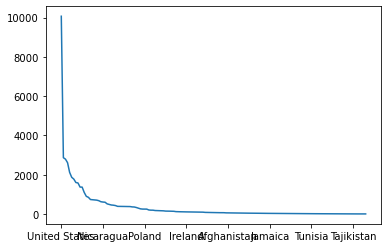

In [12]:
data['Country'].value_counts().plot()

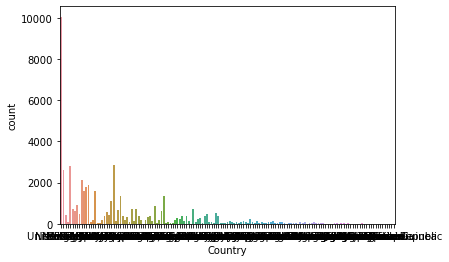

In [24]:
sns.countplot(data['Country'], figsize=())

As maximum number of our Customers belong to United States , I will restrict data to only United States

In [25]:
sales_us = data[data['Country']=='United States']
#check the shape
sales_us.shape

(10064, 15)

In [26]:
#restrict the data to one full year because it's better to use a metric per Months or Years in RFM
sales_us = sales_us[sales_us['Order_Date']>= "2019-04-01"]
sales_us.shape

(6697, 15)

In [27]:
sales_us.head()

,Sno,Category,City,State,Country,Customer_ID,Order_Date,Order_Priority,Product_ID,Ship_Mode,Sub_Cat,Discount,Profit,Quantity,Unit_Price
17550,17551,Fashion,Oakland,California,United States,3912,2019-04-01,High,OFF-ST-10000617,Second Class,Watch,0%,1,3,3.0
17556,17557,Fashion,New York City,New York,United States,3176,2019-04-01,Low,OFF-LA-10001045,Standard Class,Pants,0%,2,2,3.0
17564,17565,Fashion,Jacksonville,Florida,United States,1822,2019-04-01,Medium,OFF-BI-10004002,Standard Class,Sarees,70%,-8,2,5.0
17565,17566,Fashion,Clinton,Maryland,United States,1995,2019-04-01,Medium,OFF-BI-10004001,Standard Class,Sarees,0%,71,9,17.0
17566,17567,Fashion,Dublin,Ohio,United States,6957,2019-04-01,Medium,OFF-BI-10002852,First Class,Sarees,70%,-14,4,5.0


In [30]:
print("Summary..")
#exploring the unique values of each attribute
print("Number of transactions: ",sales_us['Product_ID'].nunique())
print("Number of products bought: ",sales_us['Quantity'].nunique())
print("Number of customers:", sales_us['Customer_ID'].nunique() )
print("Percentage of customers NA: ", round(sales_us['Customer_ID'].isnull().sum() * 100 / len(data),2),"%" )

Summary..
Number of transactions:  1886
Number of products bought:  14
Number of customers: 4709
Percentage of customers NA:  0.0 %


# RFM Analysis
RFM (Recency, Frequency, Monetary) analysis is a customer segmentation technique that uses past purchase behavior to divide customers into groups. RFM helps divide customers into various categories or clusters to identify customers who are more likely to respond to promotions and also for future personalization services.

RECENCY (R): Days since last purchase

FREQUENCY (F): Total number of purchases

MONETARY VALUE (M): Total money this customer spent.

We will create those 3 customer attributes for each customer.

# Recency
To calculate recency, we need to choose a date point from which we evaluate how many days ago was the customer's last purchase.

In [31]:
#last date available in our data set
sales_us['Order_Date'].max()

'2021-02-28'

The last date which we have is '2021-02-28' we will use this as our reference

In [33]:
now = dt.date(2021,2,28)
print(now)

2021-02-28


In [35]:
# Creating a new column called date which contains date of order only 
sales_us['date']=pd.DatetimeIndex(sales_us['Order_Date']).date

In [36]:
sales_us.head()

,Sno,Category,City,State,Country,Customer_ID,Order_Date,Order_Priority,Product_ID,Ship_Mode,Sub_Cat,Discount,Profit,Quantity,Unit_Price,date
17550,17551,Fashion,Oakland,California,United States,3912,2019-04-01,High,OFF-ST-10000617,Second Class,Watch,0%,1,3,3.0,2019-04-01
17556,17557,Fashion,New York City,New York,United States,3176,2019-04-01,Low,OFF-LA-10001045,Standard Class,Pants,0%,2,2,3.0,2019-04-01
17564,17565,Fashion,Jacksonville,Florida,United States,1822,2019-04-01,Medium,OFF-BI-10004002,Standard Class,Sarees,70%,-8,2,5.0,2019-04-01
17565,17566,Fashion,Clinton,Maryland,United States,1995,2019-04-01,Medium,OFF-BI-10004001,Standard Class,Sarees,0%,71,9,17.0,2019-04-01
17566,17567,Fashion,Dublin,Ohio,United States,6957,2019-04-01,Medium,OFF-BI-10002852,First Class,Sarees,70%,-14,4,5.0,2019-04-01


In [41]:
sales_us.columns

Index(['Sno', 'Category', 'City', 'State', 'Country', 'Customer_ID',
       'Order_Date', 'Order_Priority', 'Product_ID', 'Ship_Mode', 'Sub_Cat',
       'Discount', 'Profit', 'Quantity', 'Unit_Price', 'date'],
      dtype='object')

In [38]:
#group by customers and check last date of purchase
recency_df = sales_us.groupby(by='Customer_ID', as_index=False)['date'].max()
recency_df.columns = ['Customer_ID','LastPurchaseDate']
recency_df.head()


,Customer_ID,LastPurchaseDate
0,0,2019-05-23
1,2,2019-07-23
2,6,2019-11-26
3,12,2020-04-06
4,13,2020-10-14


In [39]:
#calculate recency
recency_df['Recency'] = recency_df['LastPurchaseDate'].apply(lambda x: (now - x).days)


In [40]:
recency_df.head()

,Customer_ID,LastPurchaseDate,Recency
0,0,2019-05-23,647
1,2,2019-07-23,586
2,6,2019-11-26,460
3,12,2020-04-06,328
4,13,2020-10-14,137


In [42]:
#drop LastPurchaseDate as we don't need it anymore
recency_df.drop('LastPurchaseDate',axis=1,inplace=True)

# Frequency
Frequency helps us to know how many times a customer purchased from us. To do that we need to check how many orders are registered by the same customer.

In [44]:
# drop duplicates
sales_us_copy = sales_us
sales_us_copy.drop_duplicates(subset=['Order_Date', 'Customer_ID'], keep="first", inplace=True)
#calculate frequency of purchases
frequency_df = sales_us_copy.groupby(by=['Customer_ID'], as_index=False)['Order_Date'].count()
frequency_df.columns = ['Customer_ID','Frequency']
frequency_df.head()

,Customer_ID,Frequency
0,0,2
1,2,1
2,6,1
3,12,2
4,13,1


# Monetary
Monetary attribute answers the question: How much money did the customer spent over time?

To do that, first, we will create a new column total cost to have the total Unit  price per Order.

In [47]:
#Create column total cost 
sales_us['Total_Cost']=sales_us['Quantity']*sales_us['Unit_Price']

In [50]:
monetary_df = sales_us.groupby(by='Customer_ID',as_index=False).agg({'Total_Cost':'sum'})
monetary_df.columns = ['Customer_ID','Monetary']
monetary_df.head()

,Customer_ID,Monetary
0,0,62.0
1,2,72.0
2,6,200.0
3,12,106.0
4,13,477.0


# Create RFM  Table

In [51]:
#merge recency dataframe with frequency dataframe
temp_df = recency_df.merge(frequency_df,on='Customer_ID')
temp_df.head()

,Customer_ID,Recency,Frequency
0,0,647,2
1,2,586,1
2,6,460,1
3,12,328,2
4,13,137,1


In [52]:
#merge with monetary dataframe to get a table with the 3 columns
rfm_df = temp_df.merge(monetary_df,on='Customer_ID')
#use CustomerID as index
rfm_df.set_index('Customer_ID',inplace=True)
#check the head
rfm_df.head()

,Recency,Frequency,Monetary
Customer_ID,,,
0,647,2,62.0
2,586,1,72.0
6,460,1,200.0
12,328,2,106.0
13,137,1,477.0


In [56]:
print(rfm_df)

             Recency  Frequency  Monetary
Customer_ID                              
0                647          2      62.0
2                586          1      72.0
6                460          1     200.0
12               328          2     106.0
13               137          1     477.0
...              ...        ...       ...
9265             645          1      12.0
9266             168          3     155.0
9267             286          2     183.0
9268             161          2     318.0
9271             271          2     381.0

[4709 rows x 3 columns]


# RFM Table Correctness Verification

In [57]:
sales_us[sales_us['Customer_ID']==4809]

,Sno,Category,City,State,Country,Customer_ID,Order_Date,Order_Priority,Product_ID,Ship_Mode,Sub_Cat,Discount,Profit,Quantity,Unit_Price,date,Total_Cost
48921,48922,Home,Concord,California,United States,4809,2021-01-10,Medium,FUR-FU-10003975,Standard Class,Furnishings,0%,4,1,43.0,2021-01-10,43.0


# Customer Segments with RFM model
The simplest way to create customers segments from RFM Model is to use Quartiles. We assign a score from 1 to 4 to Recency, Frequency and Monetary. Four is the best/highest value, and one is the lowest/worst value. A final RFM score is calculated simply by combining individual RFM score numbers.

Note: Quintiles (score from 1-5) offer better granularity, in case the business needs that but it will be more challenging to create segments since we will have 555 possible combinations. So, we will use quartiles.

RFM Quartiles

In [58]:
quantiles = rfm_df.quantile(q=[0.25,0.5,0.75])
quantiles

,Recency,Frequency,Monetary
0.25,132.0,1.0,26.0
0.50,282.0,1.0,93.0
0.75,471.0,2.0,327.0


In [59]:
quantiles.to_dict()

{'Recency': {0.25: 132.0, 0.5: 282.0, 0.75: 471.0},
 'Frequency': {0.25: 1.0, 0.5: 1.0, 0.75: 2.0},
 'Monetary': {0.25: 26.0, 0.5: 93.0, 0.75: 327.0}}

Creation of RFM segments

We will create two segmentation classes since, high recency is bad, while high frequency and monetary value is good.

In [60]:
# Arguments (x = value, p = recency, monetary_value, frequency, d = quartiles dict)
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
    
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [61]:
#create rfm segmentation table
rfm_segmentation = rfm_df
rfm_segmentation['R_Quartile'] = rfm_segmentation['Recency'].apply(RScore, args=('Recency',quantiles,))
rfm_segmentation['F_Quartile'] = rfm_segmentation['Frequency'].apply(FMScore, args=('Frequency',quantiles,))
rfm_segmentation['M_Quartile'] = rfm_segmentation['Monetary'].apply(FMScore, args=('Monetary',quantiles,))

In [62]:
rfm_segmentation.head()

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile
Customer_ID,,,,,,
0,647,2,62.0,1,3,2
2,586,1,72.0,1,1,2
6,460,1,200.0,2,1,3
12,328,2,106.0,2,3,3
13,137,1,477.0,3,1,4


In [63]:
print(rfm_segmentation)

             Recency  Frequency  Monetary  R_Quartile  F_Quartile  M_Quartile
Customer_ID                                                                  
0                647          2      62.0           1           3           2
2                586          1      72.0           1           1           2
6                460          1     200.0           2           1           3
12               328          2     106.0           2           3           3
13               137          1     477.0           3           1           4
...              ...        ...       ...         ...         ...         ...
9265             645          1      12.0           1           1           1
9266             168          3     155.0           3           4           3
9267             286          2     183.0           2           3           3
9268             161          2     318.0           3           3           3
9271             271          2     381.0           3           

Now that we have the score of each customer, we can represent our customer segmentation. First, we need to combine the scores (R_Quartile, F_Quartile,M_Quartile) together.

In [65]:
rfm_segmentation['RFMScore'] = rfm_segmentation.R_Quartile.map(str) \
                            + rfm_segmentation.F_Quartile.map(str) \
                            + rfm_segmentation.M_Quartile.map(str)
rfm_segmentation.head()

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore
Customer_ID,,,,,,,
0,647,2,62.0,1,3,2,132
2,586,1,72.0,1,1,2,112
6,460,1,200.0,2,1,3,213
12,328,2,106.0,2,3,3,233
13,137,1,477.0,3,1,4,314


Best Recency score = 4: most recently purchase. Best Frequency score = 4: most quantity purchase. Best Monetary score = 4: spent the most.

Let's see who our Loyal(best customers) are

In [66]:
rfm_segmentation[rfm_segmentation['RFMScore']=='444'].sort_values('Monetary', ascending=False).head(10)

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore
Customer_ID,,,,,,,
229,25,54,15676.0,4,4,4,444
4971,30,3,10075.0,4,4,4,444
347,14,52,9886.0,4,4,4,444
8679,48,3,6423.0,4,4,4,444
3941,13,3,4954.0,4,4,4,444
777,120,3,4149.0,4,4,4,444
3861,3,3,3564.0,4,4,4,444
6802,82,4,3405.0,4,4,4,444
8521,57,4,3048.0,4,4,4,444


# How many customers do we have in each segment

In [67]:
print("Best Customers: ",len(rfm_segmentation[rfm_segmentation['RFMScore']=='444']))
print('Loyal Customers: ',len(rfm_segmentation[rfm_segmentation['F_Quartile']==4]))
print("Big Spenders: ",len(rfm_segmentation[rfm_segmentation['M_Quartile']==4]))
print('Almost Lost: ', len(rfm_segmentation[rfm_segmentation['RFMScore']=='244']))
print('Lost Customers: ',len(rfm_segmentation[rfm_segmentation['RFMScore']=='144']))
print('Lost Cheap Customers: ',len(rfm_segmentation[rfm_segmentation['RFMScore']=='111']))

Best Customers:  103
Loyal Customers:  358
Big Spenders:  1177
Almost Lost:  31
Lost Customers:  5
Lost Cheap Customers:  366
